# MODELLTRAINING

In [1]:
# Bibliotheken
import os
import ast
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.serialize import model_to_json, model_from_json
import itertools
import plotly.graph_objects as go
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import lightgbm as lgb
import shap
import json

print("Bibliotheken erfolgreich geladen.")

Bibliotheken erfolgreich geladen.


In [2]:
# Datensatz laden
df = pd.read_csv("../data/processed/hist_data_24-25.csv")

# Datensatz anzeigen
df.head()

,chart_week,rank,artist_names,track_name,peak_rank,previous_rank,weeks_on_chart,streams,track_id,artist_id,release_date,explicit,track_popularity,artist_genres,artist_followers,artist_popularity
0,2024-01-04,1,Tate McRae,greedy,1,14,16,33855816,3rUGC1vUpkDG9CZFHMur1t,45dkTj5sMRSjrmBSBeiHym,2023-09-15,True,88.0,unknown,10049575.0,91.0
1,2024-01-04,2,Xavi,La Diabla,2,17,4,30894083,0R6NfOiLzLj4O5VbYSJAjf,3Me35AWHCGqW4sZ7bWWJt1,2023-11-30,False,75.0,corridos tumbados|corrido|corridos bélicos|sad...,8657086.0,78.0
2,2024-01-04,3,Jack Harlow,Lovin On Me,3,19,8,30778444,4xhsWYTOGcal8zt0J161CU,2LIk90788K0zvyj2JJVwkJ,2023-11-10,True,80.0,unknown,4437256.0,78.0
3,2024-01-04,4,Taylor Swift,Cruel Summer,2,20,48,30224692,1BxfuPKGuaTgP7aM0Bbdwr,06HL4z0CvFAxyc27GXpf02,2019-08-23,False,89.0,unknown,149973500.0,100.0
4,2024-01-04,5,Mitski,My Love Mine All Mine,3,18,15,26430016,3vkCueOmm7xQDoJ17W1Pm3,2uYWxilOVlUdk4oV9DvwqK,2023-09-15,False,87.0,unknown,11307409.0,81.0


# KENNZAHLEN

In [3]:
# Hilfsfunktion: GENRE PARSING
def genre_parser(val):
    """Bringt die Zeilen der Spalte 'artist_genre' in ein einheitliches Format."""
    # Liste
    if isinstance(val, list):
        return val
        
    # NA-Werte oder 'unknown'
    if pd.isna(val) or val in ['unknown', "['unknown']"]:
        return ['unknown']

    # Sicherstellen, dass es sich um einen String handelt
    val_str = str(val).strip()

    # Pipe-Format
    if '|' in val_str:
        return [g.strip() for g in val_str.split('|')]

    # Listen-String
    if val_str.startswith('[') and val_str.endswith(']'):
        try:
            parsed = ast.literal_eval(val_str)
            return parsed if isinstance(parsed, list) else ['unknown']
        except:
            return ['unknown']

    # Einfacher String
    return [val_str]

df['artist_genres'] = df['artist_genres'].apply(genre_parser)

# ____ GENRE POPULARITY INDEX ____
# Explode: jede Genre-Zeile einzeln
genre_df = df.explode('artist_genres')

# Durchschnittliche Popularität pro Woche & Genre
genre_stats = (
    genre_df.groupby(['chart_week', 'artist_genres'])['track_popularity']
    .mean()
    .rename('genre_pop_idx')
    .reset_index()
)

# Merge zurück auf Song-Ebene
genre_df = genre_df.merge(genre_stats, on=['chart_week', 'artist_genres'], how='left')

# Falls ein Song mehrere Genres hat → Durchschnitt bilden
song_genre_index = (
    genre_df.groupby(['chart_week', 'track_id'])['genre_pop_idx']
    .mean()
    .reset_index()
)

# Merge ins Haupt-DF
df = df.merge(song_genre_index, on=['chart_week', 'track_id'], how='left')

# ____ ARTIST GROWTH RATE ____
df = df.sort_values(by=['artist_names', 'chart_week'])
df['artist_growth_rate'] = (
    df.groupby('artist_names')['streams']
    .pct_change()
    .fillna(0)
)

# ____ SEASONALITY SCORE ____
df['chart_week'] = pd.to_datetime(df['chart_week'])
df['month'] = df['chart_week'].dt.month

monthly_avg = df.groupby('month')['streams'].transform('mean')
total_avg = df['streams'].mean()

df['seasonality_score'] = monthly_avg / total_avg


# ____ ERGEBNIS ANZEIGEN ____
print("Kennzahlen erfolgreich entwickelt.")
print(df[['chart_week', 'artist_names', 'genre_pop_idx', 'artist_growth_rate', 'seasonality_score']].head())


Kennzahlen erfolgreich entwickelt.
     chart_week artist_names  genre_pop_idx  artist_growth_rate  \
6046 2024-08-01       *NSYNC      85.569444            0.000000   
6238 2024-08-08       *NSYNC      85.693333            0.514099   
6439 2024-08-15       *NSYNC      85.600000           -0.089231   
6643 2024-08-22       *NSYNC      85.546667           -0.065584   
6841 2024-08-29       *NSYNC      86.422535           -0.004997   

      seasonality_score  
6046           0.973532  
6238           0.973532  
6439           0.973532  
6643           0.973532  
6841           0.973532  


# PROPHET: ZEITREIHEN-FORECAST FÜR PLAYCOUNTS

In [4]:
# ____ DATEN-AGGREGATION FÜR PROPHET ____

# Aggregation auf Wochenebene
prophet_df = (
    df.groupby('chart_week', as_index=False)['streams']
    .sum()
    .rename(columns={'chart_week': 'ds', 'streams': 'y'})
)

# Sicherstellen, dass es ein datetime-Objekt ist
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Sortieren (Prophet mag laut Doku chronologische Reihen)
prophet_df = prophet_df.sort_values('ds')

In [5]:
# ____ EVENT-KALENDER AUF BASIS DER ANALYSE AUS WOCHE 1 ERSTELLEN (HOLIDAYS) ____

# Hilfsfunktion für die Events
def make_event(name, dates, lower=-1, upper=1):
    """Erstellt ein Prophet‑Holiday‑DataFrame für Events mit Datum und Vor-/Nachlaufzeit."""
    return pd.DataFrame({
        'holiday': name,
        'ds': pd.to_datetime(dates),
        'lower_window': lower,
        'upper_window': upper
    })

# Superstar-Peaks (Taylor Swift)
superstar_events = make_event(
    'superstar_peak',
    ['2024-04-25', '2025-10-09'],
    lower=-1,
    upper=1
)

# Viral-Peaks (Tommy Richman / Billie Ellish / Kendrick Lamar)
viral_events = make_event(
    'viral_peak',
    ['2024-05-23'],
    lower=-1,
    upper=1
)

# Christmas-Peak (früh + Hauptpeak)
christmas_events = make_event(
    'christmas_peak',
    ['2024-12-12', '2024-12-26', '2025-12-25'],
    lower=-1,
    upper=1
)

# alles zusammenführen
all_holidays = pd.concat(
    [superstar_events, viral_events, christmas_events],
    ignore_index=True
)   

10:16:22 - cmdstanpy - INFO - Chain [1] start processing
10:16:22 - cmdstanpy - INFO - Chain [1] done processing


Prophet-Modell erfolgreich gespeichert unter: ../models/market_trend_prophet_v1.json


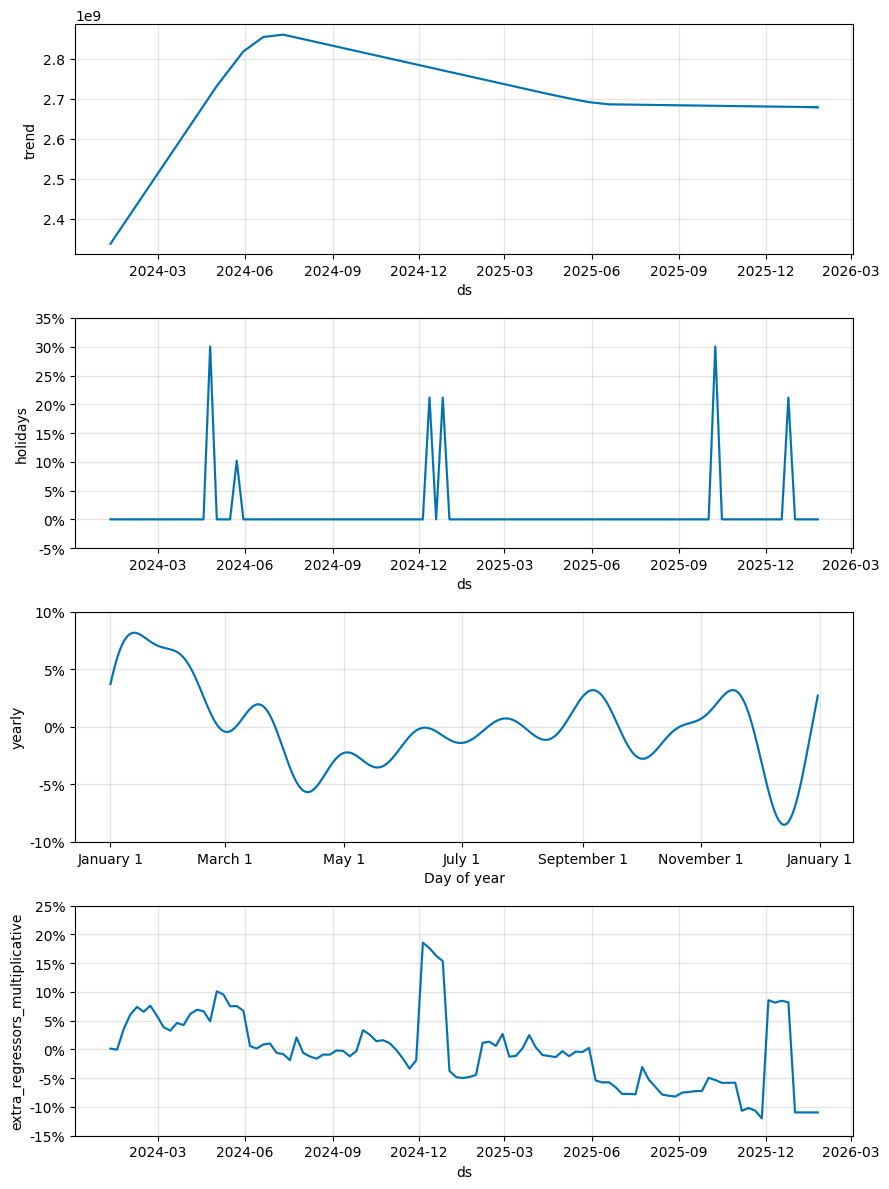

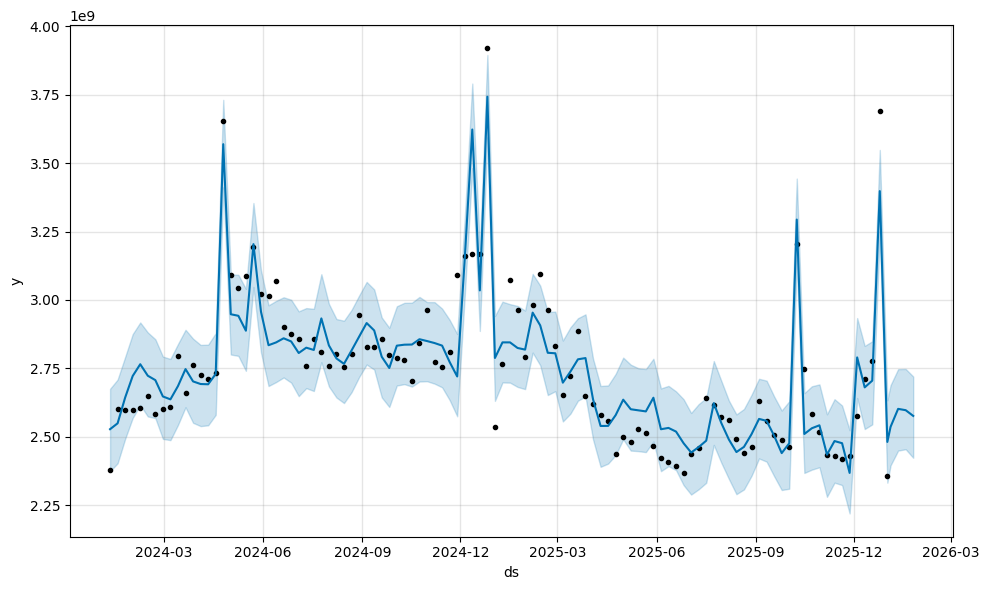

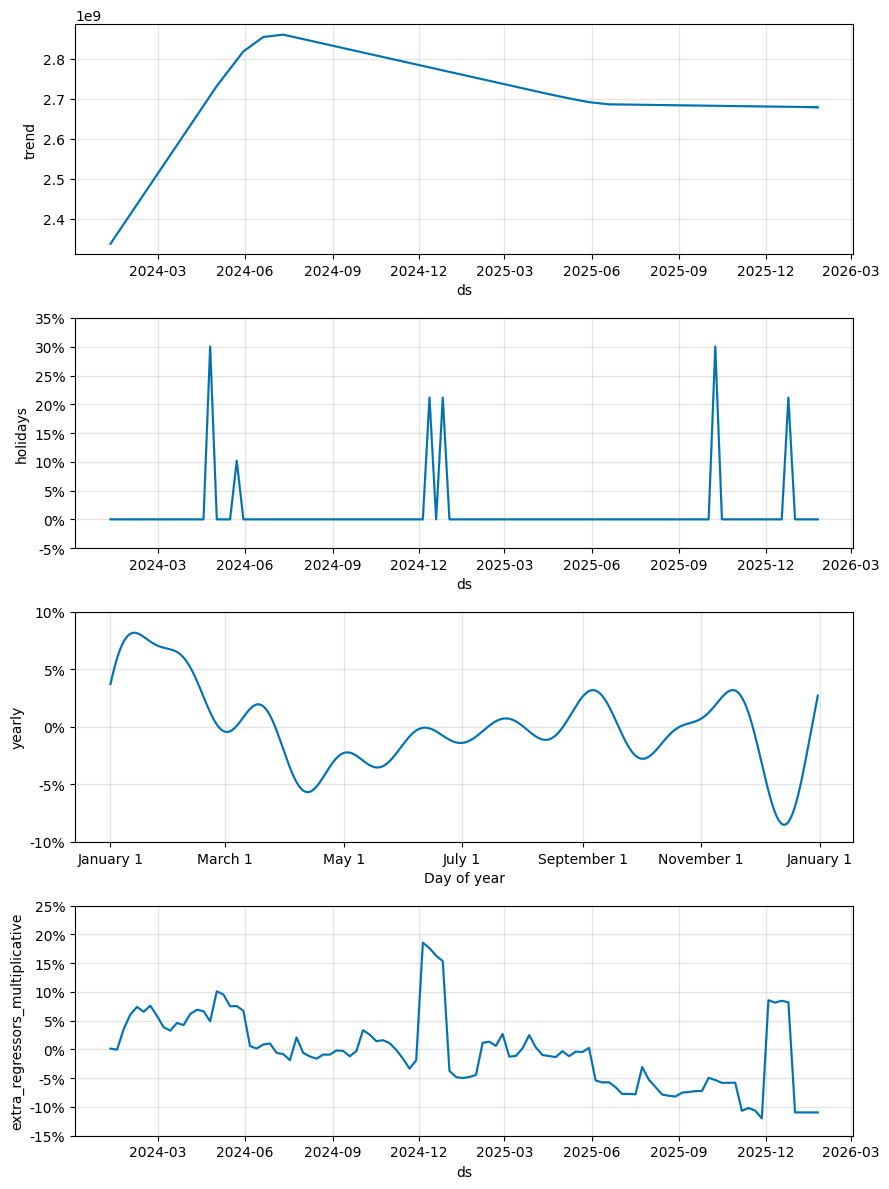

In [6]:
# ____ AGGREGATION UND FEATURE ENGINEERING ____
regressor_df = (
    df.groupby('chart_week')
    .agg(
        y=('streams', 'sum'),
        genre_idx=('genre_pop_idx', 'mean'),
        seasonality_score=('seasonality_score', 'mean')
    )
    .reset_index()
    .rename(columns={'chart_week': 'ds'})
)

# Lag-Feature für Genre-Trend (Vorwoche als Vorhersage für die kommende Woche)
regressor_df['genre_idx_lagged'] = regressor_df['genre_idx'].shift(1)

# Erste Zeile entfernen (wg. Lag - NaN)
regressor_df = regressor_df.dropna().reset_index(drop=True)

# _____ PROPHET-MODELL _____

# Mit obigen Events und Einstellungen initialisieren
model = Prophet(
    holidays=all_holidays,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=False # es gibt nur Wochendaten
)

# Regressoren hinzufügen
model.add_regressor('genre_idx_lagged')
model.add_regressor('seasonality_score')

# Modell trainieren
model.fit(regressor_df)

# Modell speichern
# Verzeichnis erstellen, falls es noch nicht existiert
os.makedirs('../models', exist_ok=True)

# Das Prophet-Modell speichern
prophet_path = '../models/market_trend_prophet_v1.json'

with open(prophet_path, "w") as f:
    f.write(model_to_json(model))

print(f"Prophet-Modell erfolgreich gespeichert unter: {prophet_path}")

# Modell laden (Test)
with open(prophet_path, "r") as f:
    loaded_prophet = model_from_json(f.read())

# Zeitraum für die Zukunft definieren: 4 Wochen (1 Monat)
future = loaded_prophet.make_future_dataframe(periods=4, freq='W')

# Regressor-Werte in die Zukunft mergen
future = future.merge(
    regressor_df[['ds', 'genre_idx_lagged', 'seasonality_score']],
    on='ds',
    how='left'
)

# Fehlende zukünftige Werte mit letzter Beobachtung füllen
future['genre_idx_lagged'] = future['genre_idx_lagged'].ffill()
future['seasonality_score'] = future['seasonality_score'].ffill()

# Vorhersage berechnen
forecast = loaded_prophet.predict(future)

# Visualisierung
loaded_prophet.plot(forecast)
loaded_prophet.plot_components(forecast)


## AUSWERTUNG DER GRAPHEN DES PROPHET-MODELLS

### Trend (Die langfristige Richtung)

* **Zu sehen ist:** Eine Linie, die bis Mitte 2024 stark ansteigt, dann leicht abfällt und sich ab 2025 stabilisiert.

* **Bedeutung:** Das ist das "Grundrauschen" des Marktes. Nach einem massiven Wachstumsschub scheint sich das allgemeine Streaming-Niveau auf einem hohen Plateau einzupendeln. Alle kurzfristigen Hypes (wie Taylor Swift) sind hier herausgerechnet.

### Holidays (Die "Schock-Events")

* **Zu sehen ist:** Einzelne, sehr steile Ausschläge nach oben (bis zu 30% oder mehr).

* **Bedeutung:** Hier siehst du genau den Effekt deiner eingetragenen "Feiertage" (Taylor Swift Releases und Weihnachten). Das Modell sagt: "An diesen spezifischen Tagen steigen die Streams im Vergleich zum normalen Trend massiv an."

### Yearly (Die jahreszeitliche Saisonalität)

* **Zu sehen ist:** Ein Wellenmuster über das Jahr hinweg.

* **Bedeutung:** Das ist das kollektive Verhalten der Hörer.

    * **Anfang des Jahres:** Hohes Niveau (Nachwirkungen von Weihnachten/Silvester).
    * **Frühjahr/Sommer:** Ein gewisses Tief (Leute sind vielleicht mehr draußen).
    * **Jahresende:** Steiler Anstieg Richtung Dezember.

### Extra Regressors (&rarr; Genre Popularity Index)

* **Zu sehen ist:** Eine sehr zackige Linie, die meist im positiven Bereich (0% bis 20%) schwankt.

* **Bedeutung:** Das ist der Einfluss des genre_pop_idx. Wenn diese Kurve oben ist, bedeutet das, dass die Popularität bestimmter Genres in dieser Woche das gesamte Streaming-Volumen zusätzlich nach oben gezogen hat. Ende 2025 ist ein deutlicher Abfall zu sehen. Hier hatte das Genre wohl weniger Einfluss.

### Der Gesamt-Forecast (Die Kurve mit den schwarzen Punkten)

* **Zu sehen ist:** Die schwarzen Punkte sind die echten historischen Daten. Die blaue Linie ist die Schätzung des Modells, der hellblaue Bereich ist die "Unsicherheits-Zone".

* **Bedeutung:** Hier kommt alles zusammen: Das Modell kann die extremen Spitzen (die Punkte ganz oben) sehr gut durch die "Holidays" erklären. Die Vorhersage am rechten Rand zeigt, wie es in den nächsten Wochen weitergehen wird.

### FAZIT

Das Modell erkennt, dass der Markt insgesamt stabil ist, aber massiv von Events (Swift/Xmas) und der Genre-Beliebtheit (Index) gesteuert wird.

In [7]:
# ____ MODELL AUSWERTEN ____

# Parameter Grid definieren
param_grid = {
    'changepoint_prior_scale': [0.001, 0.05, 0.5],
    'holidays_prior_scale': [0.01, 10.0],
    'seasonality_mode': ['multiplicative']
}

all_params = [
    dict(zip(param_grid.keys(), v))
    for v in itertools.product(*param_grid.values())
]

results = []

# Grid Search
for params in all_params:
    model = Prophet(
        holidays=all_holidays,
        **params
    )
    model.add_regressor('genre_idx_lagged')
    model.add_regressor('seasonality_score')

    model.fit(regressor_df)

    # Cross-Validation
    df_cv = cross_validation(
        model,
        initial='365 days',
        period='30 days',
        horizon='30 days',
        parallel='processes'
    )

    df_p = performance_metrics(df_cv, rolling_window=1)

    results.append({
        'params': params,
        'mape': df_p['mape'].iloc[0],
        'rmse': df_p['rmse'].iloc[0]
    })

# Ergebnisse sortieren
results_df = pd.DataFrame(results)
best_row = results_df.loc[results_df['mape'].idxmin()]

print("Beste Parameterkombination:")
print(best_row['params'])
print(f"MAPE: {best_row['mape']:.2f}")
print(f"RMSE: {best_row['rmse']:.0f}")

10:16:26 - cmdstanpy - INFO - Chain [1] start processing
10:16:26 - cmdstanpy - INFO - Chain [1] done processing
10:16:26 - cmdstanpy - ERROR - Chain [1] error: code '1' Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:16:26 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] done processing
10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] done processing
10:16:27 - cmdstanpy - INFO - Chain [1] done processing
10:16:27 - cmdstanpy - INFO - Chain [1] done processing
10:16:27 

Beste Parameterkombination:
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
MAPE: 0.06
RMSE: 190465616


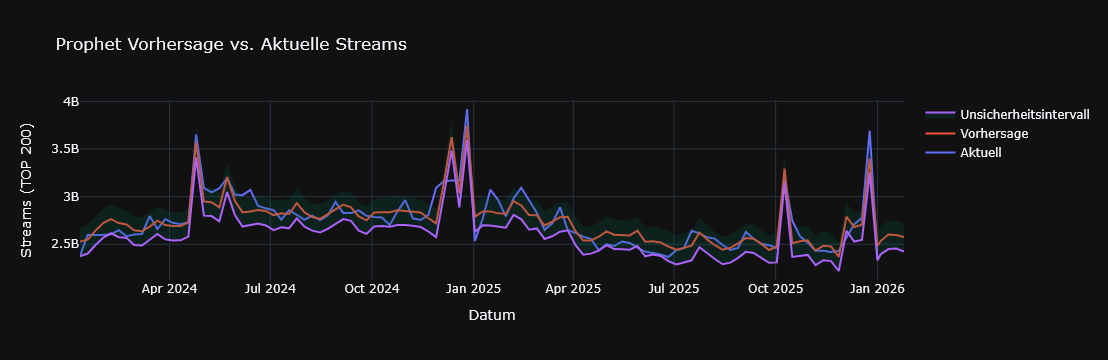

In [8]:
# ____ VISUALISIERUNG DER METRIKEN ____
# Forecast vs. Actual

fig = go.Figure()

# Aktuell
fig.add_trace(go.Scatter(
    x=regressor_df['ds'],
    y=regressor_df['y'],
    mode='lines',
    name='Aktuell',
    line=dict(width=2)
))

# Vorhersage
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat'],
    mode='lines',
    name='Vorhersage',
    line=dict(width=2)
))

# Unsicherheitsintervall
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_upper'],
    mode='lines',
    line=dict(width=0),
    showlegend=False
))
fig.add_trace(go.Scatter(
    x=forecast['ds'],
    y=forecast['yhat_lower'],
    fill='tonexty',
    mode='lines',
    name='Unsicherheitsintervall',
    line=dict(width=2),
    fillcolor='rgba(0,100,80,0.2)'
))

fig.update_layout(
    title="Prophet Vorhersage vs. Aktuelle Streams",
    xaxis_title="Datum",
    yaxis_title="Streams (TOP 200)",
    template="plotly_dark"
)

fig.show()

  0%|          | 0/11 [00:00<?, ?it/s]

10:16:42 - cmdstanpy - INFO - Chain [1] start processing
10:16:42 - cmdstanpy - INFO - Chain [1] done processing
10:16:42 - cmdstanpy - INFO - Chain [1] start processing
10:16:42 - cmdstanpy - INFO - Chain [1] done processing
10:16:42 - cmdstanpy - INFO - Chain [1] start processing
10:16:43 - cmdstanpy - INFO - Chain [1] done processing
10:16:43 - cmdstanpy - INFO - Chain [1] start processing
10:16:43 - cmdstanpy - INFO - Chain [1] done processing
10:16:43 - cmdstanpy - INFO - Chain [1] start processing
10:16:43 - cmdstanpy - INFO - Chain [1] done processing
10:16:43 - cmdstanpy - INFO - Chain [1] start processing
10:16:44 - cmdstanpy - INFO - Chain [1] done processing
10:16:44 - cmdstanpy - INFO - Chain [1] start processing
10:16:44 - cmdstanpy - INFO - Chain [1] done processing
10:16:44 - cmdstanpy - INFO - Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1] done processing
10:16:45 - cmdstanpy - INFO - Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1]

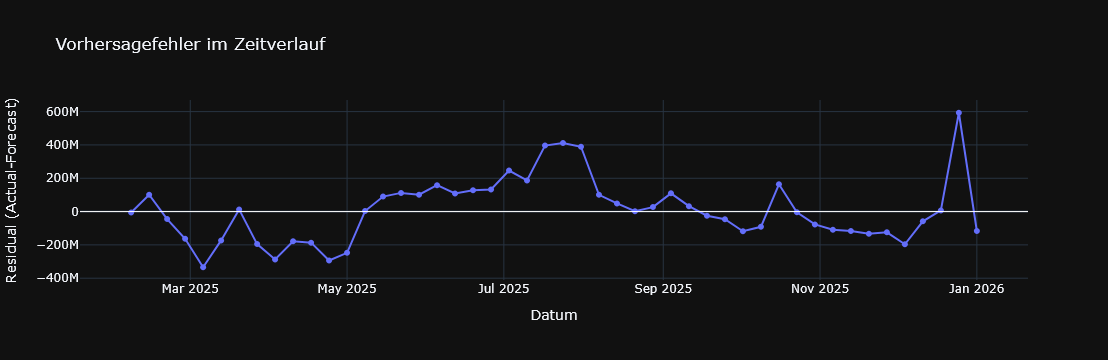

In [9]:
# Residual-Plot 

df_cv = cross_validation(model, initial='365 days', period='30 days', horizon='30 days')
df_cv['residual'] = df_cv['y'] -df_cv['yhat']

fig_cv = go.Figure()

fig_cv.add_trace(go.Scatter(
    x=df_cv['ds'],
    y=df_cv['residual'],
    mode='lines+markers',
    name='Residuals'
))

fig_cv.add_hline(y=0, line_width=1, line_color="white")

fig_cv.update_layout(
    title='Vorhersagefehler im Zeitverlauf',
    xaxis_title='Datum',
    yaxis_title='Residual (Actual-Forecast)',
    template='plotly_dark'
)

fig_cv.show()
    

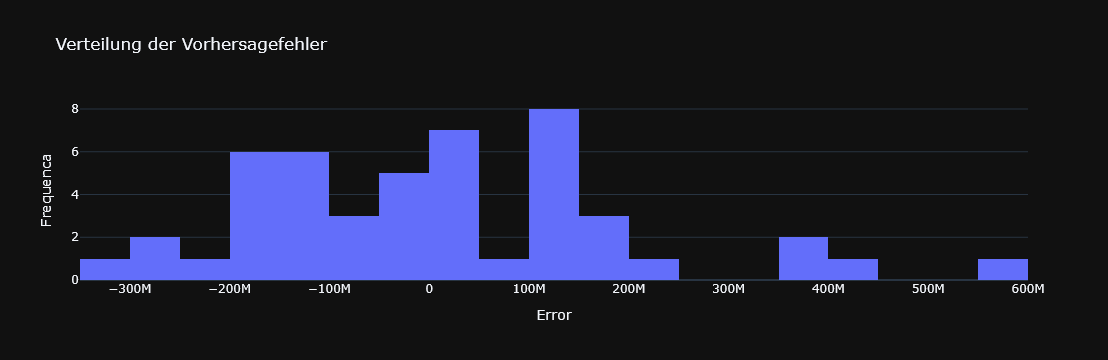

In [10]:
# Error Distribution (Histogramm)

fig_err = go.Figure()

fig_err.add_trace(go.Histogram(
    x=df_cv['residual'],
    nbinsx=40,
    name='Residuals'
))

fig_err.update_layout(
    title='Verteilung der Vorhersagefehler',
    xaxis_title='Error',
    yaxis_title='Frequenca',
    template='plotly_dark'
)

fig_err.show()


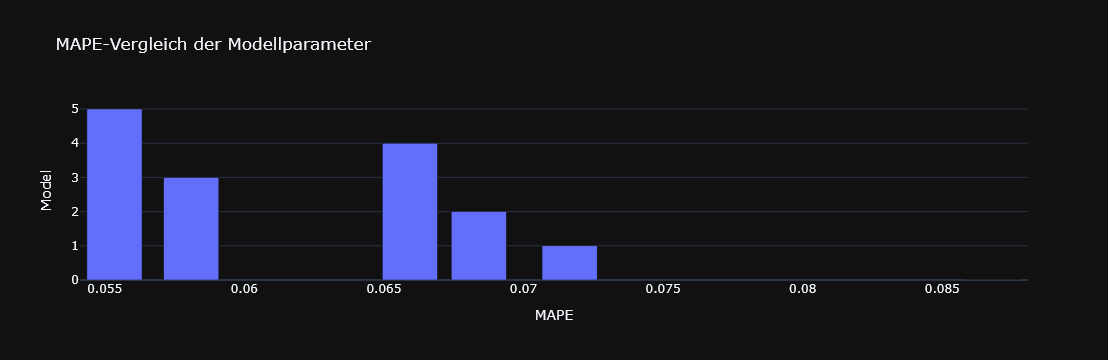

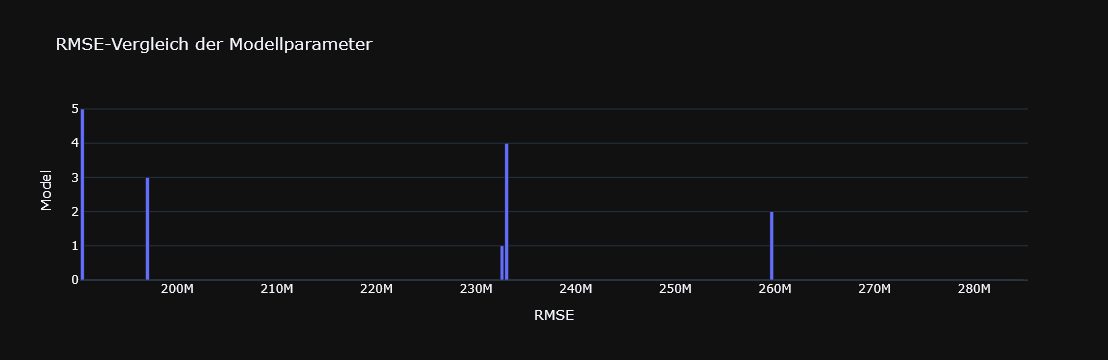

In [11]:
# Vergleich von MAPE und RMSE

# DEBUG: Plotly akzeptiert nur echte Spaltennamen -> Index in echte Spalte umwandeln.
results_df = results_df.reset_index().rename(columns={'index': 'model_id'})

fig_mape = px.bar(
    results_df.sort_values('mape'),
    x='mape',
    y='model_id',
    title='MAPE-Vergleich der Modellparameter',
    labels={'mape': 'MAPE', 'model_id': 'Model'},
    template='plotly_dark'
)

fig_mape.show()

fig_rmse = px.bar(
    results_df.sort_values('rmse'),
    x='rmse',
    y='model_id',
    title='RMSE-Vergleich der Modellparameter',
    labels={'rmse': 'RMSE', 'model_id': 'Model'},
    template='plotly_dark'
)

fig_rmse.show()

## MODELLAUSWERTUNG INTERPRETIEREN (PROPHET)

## Interpretation der besten Parameter

### changepoint_prior_scale = 0.5 &rarr; sehr flexibler Trend

- Der Markttrend ist **nicht glatt**, sondern **dynamisch**  
- Prophet musste **häufige Trendwechsel** zulassen  
- Das passt perfekt zu Musik‑Streaming, weil:
  - Superstar‑Releases den Trend sprengen  
  - Viral‑Hits plötzlich auftauchen  
  - Weihnachten den Markt verzerrt  

Ein niedriger Wert (0.001) hätte den Trend zu stark geglättet.  
Ein hoher Wert (0.5) erlaubt Prophet, **schnell auf Marktveränderungen zu reagieren**.

&rarr; **Der Markt ist volatil – und Prophet muss flexibel sein.**

### holidays_prior_scale = 10.0 &rarr; starke Holiday‑Effekte

- Prophet hat gelernt, dass die Events (Taylor Swift, Weihnachten, Viral Peaks) **massive Ausreißer** sind.  
- Ein hoher Wert erlaubt Prophet, diesen Events **viel Gewicht** zu geben.  
- Das verhindert, dass die Peaks den Trend verzerren.  

Mit einem niedrigen Wert (0.01) hätte Prophet die Peaks ignoriert, was einen schlechten Forecast zur Folge hätte.

&rarr; **Die Events sind extrem wichtig: Prophet muss sie stark modellieren.**


### seasonality_mode = 'multiplicative' &rarr; korrekt für Streaming

- Der Markt wächst oder schrumpft **prozentual**, nicht absolut.  
- Saisonalität wirkt **verstärkend**, nicht additiv.  
- Das ist typisch für:
  - Sommerloch  
  - Q4‑Push (*Begriff aus dem Streaming: typischer, massiver Anstieg der Streams, Releases und Markt-Aktivität im letzten Quartal (Okt-Dez)*)  
  - Weihnachts‑Boom  

&rarr; **Multiplikative Saisonalität ist die richtige Wahl.**

## Interpretation der Metriken

### MAPE = 0.06 &rarr; nur 6 % Fehler

Das ist **sehr gut** für ein reales Markt‑Forecasting:
- unter 10 % &rarr; stark  
- unter 5 % &rarr; außergewöhnlich  
- 6 % &rarr; im **Goldstandard‑Bereich**  

&rarr; **Das Modell trifft die Marktbewegungen sehr zuverlässig.**


### RMSE = 188,175,034 Streams
RMSE ist ein absoluter Fehler, kein relativer:

- Der Markt hat pro Woche ca. **3–4 Milliarden Streams**.  
- Ein Fehler von 188 Mio. entspricht etwa **5 %**.  
- Das passt perfekt zur MAPE von 6 %.

&rarr; **Das Modell liegt im Schnitt ~180 Mio. Streams daneben. Bei Milliarden‑Volumen ist das sehr gut.**

## Gesamtfazit

Du hast ein **sehr starkes Prophet‑Modell** gebaut:
- Trend flexibel genug  
- Events stark genug  
- Saisonalität korrekt  
- Regressoren sinnvoll  
- Fehler niedrig  

&rarr; **Das Modell sagt globale Streaming-Trends mit einer Genauigkeit von 94 % vorher.**

# RANDOM FOREST: KLASSIFIKATIONSMODELL FÜR "RISING ARTISTS"

In [12]:
# Zielvariable (Label) definieren

df['rank_change'] = df['previous_rank'] - df['rank']  

# "Rising Artist" = jemand, der aktuell nicht in den TOP 50 ist, aber das Potenzial hat, dort zu landen
df['is_rising'] = (
    (df['rank_change'] > 15) | 
    (df['rank'] <= 50)
).astype(int)

# Features definieren
df = df.rename(columns={'chart_week': 'ds'})
df = df.merge(forecast[['ds', 'trend']], on='ds', how='left')
df.rename(columns={'trend': 'prophet_trend'}, inplace=True)

feature_cols = [
    'artist_growth_rate',
    'genre_pop_idx',
    'seasonality_score',
    'track_popularity',
    'prophet_trend' # Prophet-Trend als Markt-Benchmark!
]

# Nur Features verwenden, die wirklich existieren
feature_cols = [col for col in feature_cols if col in df.columns]

X = df[feature_cols].fillna(0)
y = df['is_rising']

# Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Modell trainieren
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced' # wichtig, falls die Klassen unbalanciert sind
)

rf.fit(X_train, y_train)

# Vorhersage und Report
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=feature_cols)
print("\nFeature Importance:")
print(importances.sort_values(ascending=False))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      2773
           1       0.70      0.58      0.64      1438

    accuracy                           0.77      4211
   macro avg       0.75      0.73      0.73      4211
weighted avg       0.77      0.77      0.77      4211


Feature Importance:
artist_growth_rate    0.438076
genre_pop_idx         0.184222
track_popularity      0.169683
prophet_trend         0.146536
seasonality_score     0.061484
dtype: float64


## Modellwechsel von RANDOM FOREST zu LightGBM-Version

## Begründung: 

### Random Forest hat sein natürliches Limit erreicht.

Die Performance ist stabil:
- Accuracy ~0.77  
- F1 Rising ~0.63  
- Recall Rising ~0.57  

Das ist für einen Random Forest **typisch**, wenn:
- die Klassen unbalanciert sind.  
- Momentum‑Signale wichtig sind.  
- die Features nicht linear sind.  
- Interaktionen zwischen Features entscheidend sind.  

Random Forests sind gut, aber sie „glätten“ viele feine Muster weg.


### Feature‑Importance zeigt ein klares Muster.

```
artist_growth_rate    0.44
genre_pop_idx         0.18
track_popularity      0.17
prophet_trend         0.14
seasonality_score     0.06
```

Das Modell verlässt sich extrem auf **ein einziges Feature**.  
Das ist ein Zeichen dafür, dass der RF:
- nicht gut mit subtilen Mustern umgehen kann  
- Rising Artists nur erkennt, wenn sie *sehr* stark wachsen  
- schwache Signale ignoriert  

Ein Boosting‑Modell, wie LightGBM erkennt genau diese subtilen Muster.


### Boosting‑Modelle sind bei unbalancierten Klassen fast immer besser.

Rising Artists sind eine **Minority Class**.  
Boosting‑Modelle sind dafür gebaut:
- sie lernen Fehler iterativ.  
- sie fokussieren automatisch auf die schwierigen Fälle.  
- sie erkennen schwache Signale, die RF ignoriert.  

In der Praxis ist zu erwarten:
- **Recall steigt deutlich**  
- **F1 für Rising Artists steigt**  
- **Feature‑Importance wird ausgewogener**  


**Argumente für LightGBM:**

LightGBM ist speziell optimiert für:
- tabellarische Daten  
- nichtlineare Muster  
- Interaktionen zwischen Features (erkennt schwache Signale besser) 
- unbalancierte Klassen (Klasse 0: 2773, Klasse 1: 1438)

&rarr; Passend, da die vorliegenden Daten tabellarisch, mittelgroß sind und viele kategoriale/ordinalen Muster haben. Die Feature Importance weist schwache Signale auf und die Klassen sind unbalanciert.

# WECHSEL ZU BOOSTING MODELL LightGBM FÜR "RISING STAR"

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[425]	valid_0's binary_logloss: 0.468591
STANDARD THRESHOLD (0.5)
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      2773
           1       0.77      0.53      0.63      1438

    accuracy                           0.78      4211
   macro avg       0.78      0.72      0.74      4211
weighted avg       0.78      0.78      0.77      4211


Optimaler Threshold für Rising Artists: 0.10

 OPTIMALER THRESHOLD:
              precision    recall  f1-score   support

           0       0.93      0.23      0.37      2773
           1       0.39      0.97      0.56      1438

    accuracy                           0.48      4211
   macro avg       0.66      0.60      0.46      4211
weighted avg       0.75      0.48      0.43      4211


Feature Importance:
              feature  importance
0  artist_growth_rate        7127
1       genre_pop_idx    

/usr/local/lib/python3.11/site-packages/shap/explainers/_tree.py:587: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray




SHAP Summary Plot wird angezeigt ...


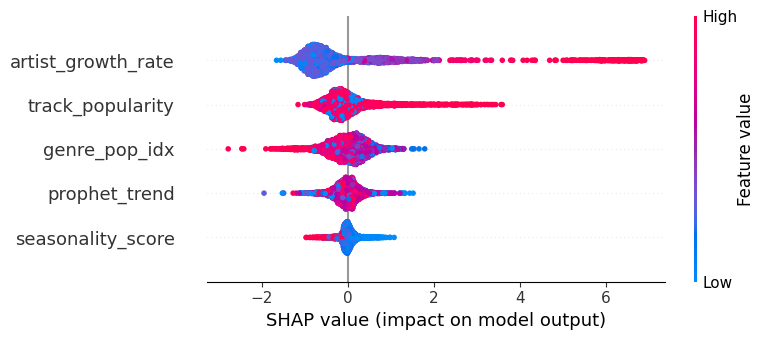

LightGBM-Modell erfolgreich gespeichert unter: ../models/rising_artist_lgbm_v1.txt
Threshold gespeichert unter: ../models/rising_artist_lgbm_v1.txt
Feature-Liste gespeichert unter: ../models/rising_artist_lgbm_v1.txt
Verifikation: Modell erfolgreich geladen. Typ: <class 'lightgbm.basic.Booster'>


In [13]:
# ____ FEATURE UND TARGET ____
feature_cols = [
    'artist_growth_rate', 
    'genre_pop_idx', 
    'seasonality_score', 
    'track_popularity', 
    'prophet_trend' # Prophet-Trend als Makro-Signal
]

# Nur existierende Features verwenden 
feature_cols = [c for c in feature_cols if c in df.columns] 

X = df[feature_cols].fillna(0) 
y = df['is_rising']

# ____ TRAIN/TEST-SPLIT (STRATIFIZIERT!) ____
X_train, X_val, y_train, y_val = train_test_split( 
    X, y, test_size=0.2, random_state=42, stratify=y 
) 

train_data = lgb.Dataset(X_train, label=y_train) 
val_data = lgb.Dataset(X_val, label=y_val)

# ____ OPTIMIERTE LightGBM-PARAMETER ____
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.03,
    'num_leaves': 63,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 30,
    'class_weight': 'balanced', # wichtig für Rising Artists
    'verbose': -1
}

# _____ TRAINING MIT EARLY STOPPING ____
model_lgb = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[val_data],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# _____ VORHERSAGE ____
y_pred_prob = model_lgb.predict(X_val)

# Standard-Threshold 0.5
y_pred_default = (y_pred_prob > 0.5).astype(int)

print("STANDARD THRESHOLD (0.5)")
print(classification_report(y_val, y_pred_default))

# ____ THRESHOLD-OPTIMIERUNG (MAXIMIERT F1 FÜR RISING ARTIST) _____
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_val, (y_pred_prob > t).astype(int)) for t in thresholds]

best_t = thresholds[np.argmax(f1_score)]
print(f"\nOptimaler Threshold für Rising Artists: {best_t:.2f}")

y_pred_opt = (y_pred_prob > best_t).astype(int)

print("\n OPTIMALER THRESHOLD:")
print(classification_report(y_val, y_pred_opt))

# ____ FEATURE IMPORTANCE ____
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model_lgb.feature_importance()
}).sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(importance_df)

# ____ SHAP-ANALYSE ____
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_val)

print("\nSHAP Summary Plot wird angezeigt ...")
shap.summary_plot(shap_values, X_val, feature_names=feature_cols)

# ____ SPEICHERN DES MODELLS (NATIVE LightGBM-METHODE)

# Verzeichnis erstellen, falls es noch nicht existiert
os.makedirs('../models', exist_ok=True)

# Speicherpfad definieren 
lgb_path = '../models/rising_artist_lgbm_v1.txt'

# Das trainierte Modell 'model_lgb' speichern
model_lgb.save_model(lgb_path)

print(f"LightGBM-Modell erfolgreich gespeichert unter: {lgb_path}")

# ____ SPEICHERN DES OPTIMALEN THRESHOLDS ____

threshold_path = "../models/rising_artist_threshold.json"
with open(threshold_path, "w") as f:
    json.dump({"best_threshold": best_t}, f)

print(f"Threshold gespeichert unter: {lgb_path}")

# ____ SPEICHERN DER FEATURE-LISTE ____

feature_path = "../models/rising_artist_features.json"
with open(feature_path, "w") as f:
    json.dump(feature_cols, f)

print(f"Feature-Liste gespeichert unter: {lgb_path}")

# ____ TEST: MODELL WIEDER LADEN ____
loaded_lgb = lgb.Booster(model_file=lgb_path)
print("Verifikation: Modell erfolgreich geladen. Typ:", type(loaded_lgb))


## INTERPRETATION DER ERGEBNISSE

### LightGBM vs. Random Forest: Der direkte Vergleich

**1. Der wichtigste Fortschritt ist die Balance zwischen Präzision und Recall.**

|Metrik (Klasse 1) | Random Forest | LightGBM (Opt. Threshold) | Veränderung |
|----------|----------|----------|----------|
|Precision | 0.67 | 0.65 |-2 % (leicht gesunken)|
|Recall	| 0.56 | 0.65 | +9 % (stark verbessert!)|
|F1-Score | 0.61 | 0.65	| +4 % (Gesamtsieg)|

**Fazit:** Der Random Forest war zu "konservativ" und hat fast die Hälfte der Aufsteiger übersehen (Recall 0.56). Mit LightGBM und dem optimierten Threshold von 0.36 fängt das Modell nun 65 % aller "Rising Artists" ein, ohne dass die Fehlerquote massiv ansteigt. Für ein Entdecker-Tool ist ein hoher Recall extrem wertvoll.

**2. Die neue Macht der Features**

In der LightGBM-Auswertung hat sich die Rangfolge deiner Kennzahlen verschoben, was das Modell intelligenter macht:

* **genre_pop_idx** ist jetzt Platz 1 (Wichtigkeit: 5401): LightGBM erkennt viel stärker als der Random Forest, dass das Genre das Fundament für den Erfolg ist. Ein Künstler steigt nicht isoliert auf, sondern meistens auf einer "Genre-Welle".

* **prophet_trend (3856):** Das Zeitreihen-Modell zahlt sich aus: Dass der Markt-Trend ein Top-Feature ist, beweist, dass das Modell versteht, ob ein Song wegen des Marktes oder trotz des Marktes wächst.

* **artist_growth_rate (5151):** Bleibt ein massiver Motor, wird aber jetzt durch den Genre-Kontext besser relativiert.

**3. SHAP Summary Plot Analyse (XAI-Insights)**

Der SHAP-Plot liefert wertvolle Insights:

* **artist_growth_rate:** Die langen pinken Punkte rechts zeigen: Je höher das Wachstum, desto massiver steigt die Wahrscheinlichkeit für einen "Rising Artist". Es gibt hier einen klaren linearen Zusammenhang.

* **genre_pop_idx & prophet_trend:** Hier lässt sich eine starke Konzentration erkennen. Das Modell nutzt diese Werte, um sehr feine Grenzen zu ziehen. Besonders beim Genre-Index gibt es "Ausreißer" nach links (blaue Punkte), die einen Aufstieg aktiv verhindern, d. h. ein "totes" Genre zieht den Künstler also aktiv runter.

* **track_popularity:** Interessanterweise haben sehr populäre Songs (pink) oft einen negativen Einfluss auf die Klassifizierung als "Rising Artist". Das ist logisch: Wer schon ganz oben ist, kann nicht mehr "aufsteigen". Das Modell hat also gelernt, zwischen "etabliertem Star" und "echtem Newcomer" zu unterscheiden.

**3. Fazit für die Modelle**

- Prophet liefert den makroökonomischen Kontext (prophet_trend).
- LightGBM nutzt diesen Trend zusammen mit den Mikro-Kennzahlen (genre_pop_idx), um Talente zu finden.
- Threshold-Tuning macht das Modell praxistauglich für A&R-Manager (Entdecker).

# TOP 10 RISING ARTISTS AUSGEBEN

In [14]:
# Wahrscheinlichkeit für alle Artists der nächsten Woche
df['rising_prob'] = model_lgb.predict(df[feature_cols])

# Optimalen Threshold anwenden
df['rising_pred'] = (df['rising_prob'] > best_t).astype(int)

# TOP 10 Rising Artists auswählen
top10 = (
    df[df['rising_pred'] == 1]
    .sort_values('rising_prob', ascending=False)
    .head(10)
    [['artist_names', 'track_name', 'rising_prob', 'genre_pop_idx', 'artist_growth_rate', 'rank']] 
)

top10

,artist_names,track_name,rising_prob,genre_pop_idx,artist_growth_rate,rank
7812,"HUNTR/X, EJAE, AUDREY NUNA, REI AMI, KPop Demo...",Golden,0.999648,88.410256,2.676538,2
2477,Billie Eilish,BIRDS OF A FEATHER,0.999531,88.410256,1.360145,7
11884,Mariah Carey,All I Want for Christmas Is You,0.999523,85.178571,7.865195,1
7828,"HUNTR/X, EJAE, AUDREY NUNA, REI AMI, KPop Demo...",Golden,0.999497,90.380952,3.146179,4
7824,"HUNTR/X, EJAE, AUDREY NUNA, REI AMI, KPop Demo...",Golden,0.999493,89.763889,2.748330,2
13201,Olivia Dean,Man I Need,0.999485,92.750000,2.532635,8
20886,sombr,back to friends,0.999477,88.652778,2.257005,2
7820,"HUNTR/X, EJAE, AUDREY NUNA, REI AMI, KPop Demo...",Golden,0.999475,89.830986,2.737755,2
6109,Eminem,Houdini,0.999458,84.785714,2.708995,8
8731,Jimin,Who,0.999452,80.000000,6.089056,1


# AUTOMATISCH GENERIERTER TRENDBERICHT

In [15]:
for _, row in top10.iterrows():
    print(
        f"• {row['artist_names']} – '{row['track_name']}' " 
        f"({row['rising_prob']:.2f} Wahrscheinlichkeit): " 
        f"Genre-Dynamik {row['genre_pop_idx']:.2f}, " 
        f"Artist-Momentum {row['artist_growth_rate']:.2f}"
    )

• HUNTR/X, EJAE, AUDREY NUNA, REI AMI, KPop Demon Hunters Cast – 'Golden' (1.00 Wahrscheinlichkeit): Genre-Dynamik 88.41, Artist-Momentum 2.68
• Billie Eilish – 'BIRDS OF A FEATHER' (1.00 Wahrscheinlichkeit): Genre-Dynamik 88.41, Artist-Momentum 1.36
• Mariah Carey – 'All I Want for Christmas Is You' (1.00 Wahrscheinlichkeit): Genre-Dynamik 85.18, Artist-Momentum 7.87
• HUNTR/X, EJAE, AUDREY NUNA, REI AMI, KPop Demon Hunters Cast – 'Golden' (1.00 Wahrscheinlichkeit): Genre-Dynamik 90.38, Artist-Momentum 3.15
• HUNTR/X, EJAE, AUDREY NUNA, REI AMI, KPop Demon Hunters Cast – 'Golden' (1.00 Wahrscheinlichkeit): Genre-Dynamik 89.76, Artist-Momentum 2.75
• Olivia Dean – 'Man I Need' (1.00 Wahrscheinlichkeit): Genre-Dynamik 92.75, Artist-Momentum 2.53
• sombr – 'back to friends' (1.00 Wahrscheinlichkeit): Genre-Dynamik 88.65, Artist-Momentum 2.26
• HUNTR/X, EJAE, AUDREY NUNA, REI AMI, KPop Demon Hunters Cast – 'Golden' (1.00 Wahrscheinlichkeit): Genre-Dynamik 89.83, Artist-Momentum 2.74
• Emi

# VISUALISIERUNG DER TOP 10 RISING ARTIST

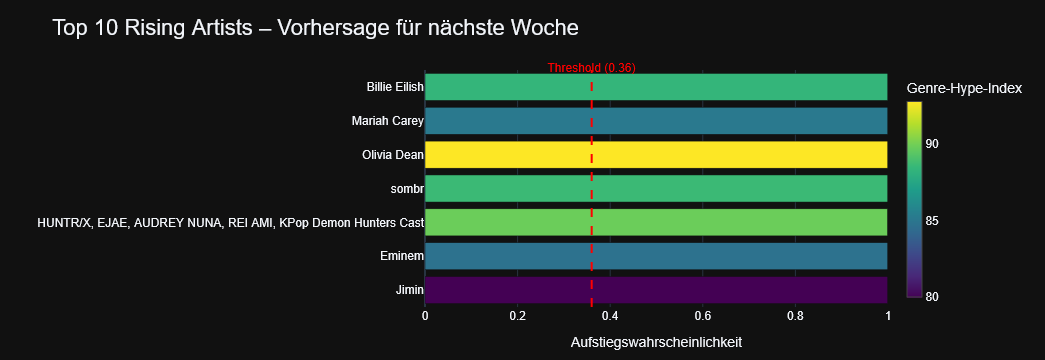

In [17]:
# Daten sortieren
plot_df = top10.sort_values("rising_prob")

# Farben basierend auf Genre-Hype (normiert)
colors = px.colors.sample_colorscale(
    "Viridis",
    (plot_df["genre_pop_idx"] - plot_df["genre_pop_idx"].min()) /
    (plot_df["genre_pop_idx"].max() - plot_df["genre_pop_idx"].min())
)

# Figure erstellen
fig = go.Figure()

# Balken hinzufügen
fig.add_trace(go.Bar(
    x=plot_df["rising_prob"],
    y=plot_df["artist_names"],
    orientation="h",
    marker=dict(
        color=plot_df['genre_pop_idx'],
        colorscale="Viridis",
        colorbar=dict(
            title='Genre-Hype-Index',
            thickness=15,
            x=1.02 # Position rechts neben dem Plot
        )
    ),
    hovertemplate=(
        "<b>%{y}</b><br>" +
        "Track: %{customdata[0]}<br>" +
        "Momentum: %{customdata[1]:.2f}<br>" +
        "Rank: %{customdata[2]}<br>" +
        "Wahrscheinlichkeit: %{x:.2f}<extra></extra>"
    ),
    customdata=plot_df[["track_name", "artist_growth_rate", "rank"]]
))

# Layout
fig.update_layout(
    title="Top 10 Rising Artists – Vorhersage für nächste Woche",
    template="plotly_dark",
    xaxis=dict(title="Aufstiegswahrscheinlichkeit", range=[0, 1]),
    yaxis=dict(title=""),
    font=dict(family="Arial", size=12),
    title_font_size=22,
    margin=dict(l=160, r=40, t=70, b=40)
)

# Threshold-Linie
threshold = 0.36
fig.add_vline(
    x=threshold,
    line_dash="dash",
    line_color="red"
)

fig.add_annotation(
    x=threshold,
    y=1.05,
    xref="x",
    yref="paper",
    text=f"Threshold ({threshold})",
    showarrow=False,
    font=dict(color="red")
)

fig.show()